In [1]:
from experiment import Experiment
from utils.m4 import (smape, mase, get_error_dict,
                      M4DatasetGenerator)
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
#
# Models
#
import torch
from models.benchmark import NaivePredictor
from models.cnn import SimpleCNN
from models.transformer import VanillaTransformer
from utils.plot import plot_predictions

## Experiment Definition

In [2]:
m4_data = M4DatasetGenerator(['Hourly'])

Epoch 1/1024 [0.667secs] -> Train loss: 0.83299 | Validation loss: 0.25603
Epoch 2/1024 [0.350secs] -> Train loss: 0.28639 | Validation loss: 0.31976
Epoch 3/1024 [0.346secs] -> Train loss: 0.28170 | Validation loss: 0.20980
Epoch 4/1024 [0.358secs] -> Train loss: 0.19545 | Validation loss: 0.14083
Epoch 5/1024 [0.342secs] -> Train loss: 0.15975 | Validation loss: 0.13953
Epoch 6/1024 [0.344secs] -> Train loss: 0.17178 | Validation loss: 0.15540
Epoch 7/1024 [0.343secs] -> Train loss: 0.18391 | Validation loss: 0.15496
Epoch 8/1024 [0.344secs] -> Train loss: 0.17797 | Validation loss: 0.14303
Epoch 9/1024 [0.343secs] -> Train loss: 0.16405 | Validation loss: 0.13391
Epoch 10/1024 [0.346secs] -> Train loss: 0.15278 | Validation loss: 0.13394
Epoch 11/1024 [0.346secs] -> Train loss: 0.14951 | Validation loss: 0.13940
Epoch 12/1024 [0.347secs] -> Train loss: 0.15410 | Validation loss: 0.14417
Epoch 13/1024 [0.351secs] -> Train loss: 0.15533 | Validation loss: 0.14470
Epoch 14/1024 [0.348s

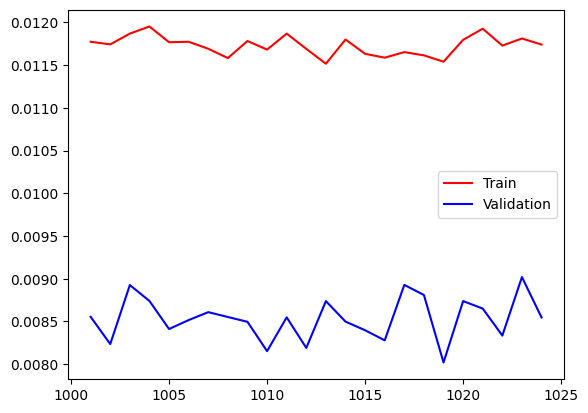

Epoch 1/1024 [0.338secs] -> Train loss: 0.71118 | Validation loss: 0.23593
Epoch 2/1024 [0.338secs] -> Train loss: 0.27775 | Validation loss: 0.26806
Epoch 3/1024 [0.336secs] -> Train loss: 0.23604 | Validation loss: 0.16346
Epoch 4/1024 [0.336secs] -> Train loss: 0.18596 | Validation loss: 0.16458
Epoch 5/1024 [0.335secs] -> Train loss: 0.19078 | Validation loss: 0.16844
Epoch 6/1024 [0.334secs] -> Train loss: 0.18875 | Validation loss: 0.16206
Epoch 7/1024 [0.333secs] -> Train loss: 0.17859 | Validation loss: 0.15838
Epoch 8/1024 [0.335secs] -> Train loss: 0.17131 | Validation loss: 0.16143
Epoch 9/1024 [0.336secs] -> Train loss: 0.17204 | Validation loss: 0.16609
Epoch 10/1024 [0.335secs] -> Train loss: 0.17120 | Validation loss: 0.16750
Epoch 11/1024 [0.338secs] -> Train loss: 0.17269 | Validation loss: 0.16514
Epoch 12/1024 [0.338secs] -> Train loss: 0.16962 | Validation loss: 0.16144
Epoch 13/1024 [0.336secs] -> Train loss: 0.16639 | Validation loss: 0.15879
Epoch 14/1024 [0.335s

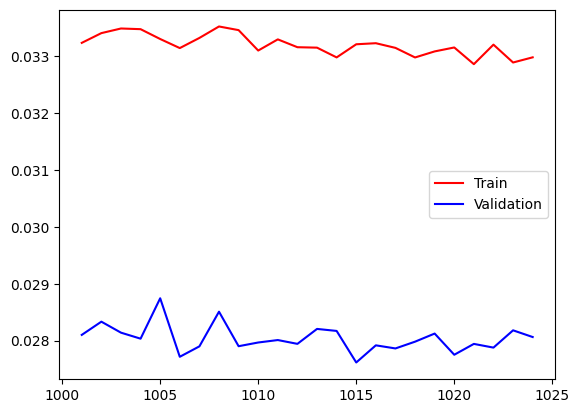

Epoch 1/1024 [0.347secs] -> Train loss: 0.38864 | Validation loss: 0.26331
Epoch 2/1024 [0.346secs] -> Train loss: 0.27698 | Validation loss: 0.20821
Epoch 3/1024 [0.348secs] -> Train loss: 0.23484 | Validation loss: 0.21315
Epoch 4/1024 [0.349secs] -> Train loss: 0.23530 | Validation loss: 0.20714
Epoch 5/1024 [0.351secs] -> Train loss: 0.22396 | Validation loss: 0.20298
Epoch 6/1024 [0.350secs] -> Train loss: 0.21958 | Validation loss: 0.20550
Epoch 7/1024 [0.351secs] -> Train loss: 0.21763 | Validation loss: 0.20395
Epoch 8/1024 [0.349secs] -> Train loss: 0.21393 | Validation loss: 0.19905
Epoch 9/1024 [0.345secs] -> Train loss: 0.20998 | Validation loss: 0.19583
Epoch 10/1024 [0.346secs] -> Train loss: 0.20687 | Validation loss: 0.19414
Epoch 11/1024 [0.348secs] -> Train loss: 0.20459 | Validation loss: 0.19041
Epoch 12/1024 [0.351secs] -> Train loss: 0.19950 | Validation loss: 0.18527
Epoch 13/1024 [0.350secs] -> Train loss: 0.19468 | Validation loss: 0.17991
Epoch 14/1024 [0.349s

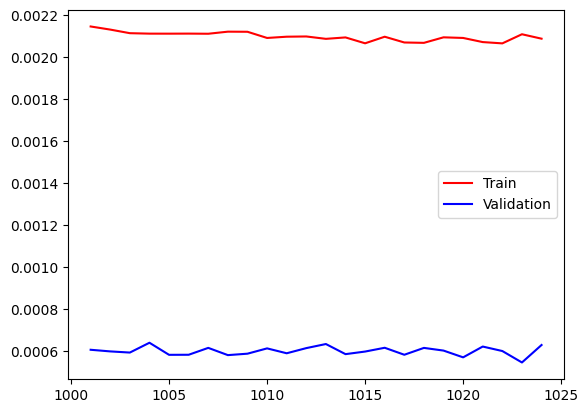

Epoch 1/1024 [0.253secs] -> Train loss: 0.51774 | Validation loss: 0.29824
Epoch 2/1024 [0.240secs] -> Train loss: 0.27747 | Validation loss: 0.20382
Epoch 3/1024 [0.241secs] -> Train loss: 0.20893 | Validation loss: 0.16210
Epoch 4/1024 [0.243secs] -> Train loss: 0.19132 | Validation loss: 0.17187
Epoch 5/1024 [0.242secs] -> Train loss: 0.19507 | Validation loss: 0.16845
Epoch 6/1024 [0.242secs] -> Train loss: 0.18959 | Validation loss: 0.16109
Epoch 7/1024 [0.242secs] -> Train loss: 0.18168 | Validation loss: 0.15968
Epoch 8/1024 [0.241secs] -> Train loss: 0.17367 | Validation loss: 0.16229
Epoch 9/1024 [0.245secs] -> Train loss: 0.16430 | Validation loss: 0.16367
Epoch 10/1024 [0.246secs] -> Train loss: 0.17937 | Validation loss: 0.16217
Epoch 11/1024 [0.238secs] -> Train loss: 0.16947 | Validation loss: 0.15964
Epoch 12/1024 [0.243secs] -> Train loss: 0.16130 | Validation loss: 0.15829
Epoch 13/1024 [0.242secs] -> Train loss: 0.16423 | Validation loss: 0.15791
Epoch 14/1024 [0.245s

In [3]:
model_name = 'vanilla_transformer'

ERRORS = {model_name:get_error_dict(['Hourly'])}
np.random.seed(123)
for train_serie, test_serie, serie_id, fh, freq, serie_sp in m4_data.generate(30, random=True):
    input_len = 24*4
    fh = len(test_serie)
    exp = Experiment(
        {
            # Model
            'model': VanillaTransformer({'d_model': 16, 'block_size':input_len,'num_heads': 4, 'num_layers': 4,'dim_feedforward':128,'device':'cuda'}),
            # 'model': SimpleCNN(input_len, model_dim=64),
            'input_len':input_len,
            'forecast_horizon':fh,
            'feature_dim':1,
            # Data
            'frequency':serie_sp.lower(),
            'scaler':MinMaxScaler((-1,1)),
            'decompose': False, #detrend and de-sazonalize
            'freq':freq,
            # Others
            'device':'cuda',
            'verbose':False,
        })
    exp.set_dataset(linear_serie=train_serie, train=True)
    exp.set_dataset(linear_serie=test_serie)
    exp.train({
        'epochs':1024,
        'validate_freq':1,
        'lr':1e-3,#1e-5,
        'batch_size':512,
        'verbose':True,
    })
    
    last_train_values = train_serie[-input_len:]
    next_validation_values = test_serie[:fh]
    pred_y = exp.predict(last_train_values, fh)
    #
    exp.print_metrics(next_validation_values, pred_y[:fh])
    #+
    plot_predictions(train_serie, next_validation_values, pred_y)
    exp.train_history(offset=100)
    # Vanila TF
    ERRORS[model_name][serie_sp]['sMAPE'].append(smape(test_serie, pred_y))
    ERRORS[model_name][serie_sp]['MASE'].append(mase(train_serie[:-fh], test_serie, pred_y, freq))  

# print("---------FINAL RESULTS---------")
for model, err in ERRORS.items():
    print(f'Model : {model}')
    for sp, sp_err in err.items():
        print(f'  {sp}: ')
        print(f'    sMAPE: {np.mean(sp_err["sMAPE"])*100:.3f}')
        print(f'    MASE: {np.mean(sp_err["MASE"]):.3f}')
  

In [ ]:
# import torch
# torch.save(exp.model, 'temp_model.model')